In [1]:
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import torch

torch.set_float32_matmul_precision("medium")  # Try "high" as well

import sys

try:
    import src
except:
    sys.path.append('../')
    import src


import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from pytorch_lightning.loggers import MLFlowLogger
import pytorch_lightning as pl
import mlflow
from typing import Tuple, List
import numpy as np

import coremltools as ct

from src.dataset import SimpleWallADE20KDataset
from src.model import WallModel
from src import config
from src.transform import get_preprocessing_transform, get_train_augmentations, get_val_augmentations, \
    get_val_augmentations_single
from src.callbacks import ModelCheckpoint, EarlyStopping, MLFlowImageLogging, LearningRateLogging

scikit-learn version 1.2.2 is not supported. Minimum required version: 0.17. Maximum required version: 1.1.2. Disabling scikit-learn conversion API.


In [2]:
# TODO: check if encoder is frozen and try unfreezing it
if config.RESUME_FROM_CHECKPOINT_PATH is not None:
    print(f'Resuming from checkpoint: {config.RESUME_FROM_CHECKPOINT_PATH}')
    wall_model = WallModel.load_from_checkpoint(config.RESUME_FROM_CHECKPOINT_PATH, init_datasets=True)
else:
    print('Training from scratch')
    wall_model = WallModel(
        architecture=config.ARCHITECTURE,
        encoder_name=config.ENCODER,
        in_channels=3,
        out_classes=1,
        learning_rate=config.LEARNING_RATE,
        init_datasets=True,
        encoder_depth=config.ENCODER_DEPTH
    )
wall_model.params

Resuming from checkpoint: ./mlruns/846943773481379712/99fcc68d050d47c990c4f341d115a86a/artifacts/model/checkpoints/epoch=91-train_loss=0.1455-val_loss=0.2121-train_dataset_iou=0.7572-val_dataset_iou=0.7075/epoch=91-train_loss=0.1455-val_loss=0.2121-train_dataset_iou=0.7572-val_dataset_iou=0.7075.ckpt


/home/ricardsku/miniconda3/envs/ml/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/ricardsku/miniconda3/envs/ml/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


{'input_space': 'RGB',
 'input_range': [0, 1],
 'mean': [0.485, 0.456, 0.406],
 'std': [0.229, 0.224, 0.225]}

In [3]:
if config.FREEZE_ENCODER:
    print("Freezing encoder params")
    for p in wall_model.model.encoder.parameters():
        p.requires_grad = False
else:
    print('Not freezing encoder')

Not freezing encoder


In [4]:
checkpoint_callback = ModelCheckpoint(
    dirpath=os.getcwd(),
    filename='{epoch}-{train_loss:.4f}-{val_loss:.4f}-{train_dataset_iou:.4f}-{val_dataset_iou:.4f}',
    save_top_k=1,
    verbose=True,
    # monitor='val_loss',
    # mode='min',
    monitor='val_dataset_iou',
    mode='max'
)

# TODO: save both best and last checkpoint (to conitnue training)

# earlystop_callback = EarlyStopping(monitor="val_loss", patience=config.EARLYSTOP_PATIENCE)
earlystop_callback = EarlyStopping(
    # monitor="val_loss",
    # mode='min',
    monitor="val_dataset_iou",
    mode='max',
    patience=config.EARLYSTOP_PATIENCE
)

MLFLOW_EXPERIMENT_NAME = 'wall_segmentation'

# TODO: use model name from config.py
# logger = TensorBoardLogger("tb_logs", name="wall_model")

In [5]:
# TODO: Adjust parameters as described in MobileOne and DeepLab papers
# MobileOne:
#  - weight decay in early stages (probably not needed, since we do transfer learning)
#  - cosine schedule for learning rate
#  - S0 and S1 we use standard augmentation – random resized cropping and horizontal flipping.
#  - We also use EMA (Exponential Moving Average) weight averaging with decay constant of 0.9995 for training all versions of MobileOne.
#  - We use MobileOne as the backbone for a Deeplab V3 segmentation network [4] using the cvnets library [45].
#  - The VOC models were trained on the augmented Pascal VOC dataset [16] for 50 epochs following the training procedure of [45] (MobileVIT). 
#    The ADE 20k [65] models were trained using the same hyperparameters and augmentations
# DeepLab:
#  - TODO

# TODO: try this config: https://github.com/apple/ml-cvnets/blob/main/config/segmentation/ade20k/deeplabv3_mobilenetv2.yaml
# batch-size 4 per GPU (4 GPUs => effective 16 batch size)
# max image size: 1024, short side min: 256, short side max: 768
# loss: cross-entropy
# lr scheduler: cosine, max
# aspp_out_channels: 512
# aspp_rates: (12, 24, 36)
# DeepLabV3 (uses encoder, hecne DeepLabV3+)
# Backbone: ResNet50
# optimizer: SGD, weight_decay: 1e-4, no_decay_bn_filter_bias: true, momentum: 0.9

# TODO: acknowledge that we calculate metrics incorrectly - we pad all images to square form, thus effectively increasing share of 'background' class
#   Ideally we would only consider original image size during calculations.

In [6]:
NUM_IMAGES_LOG = 32

val_augmentation_fn = wall_model.val_dataset.augmentation_fn

demo_dataset = SimpleWallADE20KDataset(
    root=config.DATA_ROOT,
    length=NUM_IMAGES_LOG,
    preprocessing_fn=get_preprocessing_transform(config.ENCODER),
    augmentation_fn=val_augmentation_fn,
    mode='val'
)
demo_dataset_vis = SimpleWallADE20KDataset(
    root=config.DATA_ROOT,
    length=NUM_IMAGES_LOG,
    preprocessing_fn=None,
    augmentation_fn=val_augmentation_fn,
    mode='val'
)
demo_dataloader = DataLoader(demo_dataset, batch_size=1, shuffle=False)

imagelog_callback = MLFlowImageLogging(dataset=demo_dataset, dataset_vis=demo_dataset_vis)

In [7]:
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
with mlflow.start_run() as run:
    params = {
        'max_epochs': config.MAX_EPOCHS,
        'encoder_params': wall_model.params,
        'encoder_depth': wall_model.encoder_depth,
        'learning_rate': config.LEARNING_RATE,
        'batch_size': config.BATCH_SIZE,
        'val_dataset_size': len(wall_model.val_dataset),
        'train_dataset_size': len(wall_model.train_dataset),
        'architecture': config.ARCHITECTURE,
        'encoder': config.ENCODER,
        'freeze_encoder': config.FREEZE_ENCODER,
        'input_size': config.INPUT_IMAGE_SIZE,
        'checkpoint_monitor': checkpoint_callback.monitor,
        'loss': repr(wall_model.losses),
        'optimizer': type(wall_model.optimizer).__name__,
        'scheduler': type(wall_model.scheduler).__name__
    }
    if config.RESUME_FROM_CHECKPOINT_PATH is not None:
        params['resume_from_checkpoint_path'] = config.RESUME_FROM_CHECKPOINT_PATH
    for (key, value) in wall_model.optimizer.param_groups[0].items():
        if key == 'params':
            continue
        params[f'optimizer__{key}'] = str(value)
    for (key, value) in wall_model.scheduler.state_dict().items():
        params[f'scheduler__{key}'] = str(value)
    mlflow.log_params(params)

    logger = MLFlowLogger(
        MLFLOW_EXPERIMENT_NAME,
        save_dir="./mlruns",
        log_model=True,
        run_id=run.info.run_id,
    )
    
    def log_learning_rate_metric(params):
        mlflow.log_metric('learning_rate', params['learning_rate'], step=params['global_step'])
    lr_logging_callback = LearningRateLogging(
        log_fn=log_learning_rate_metric
    )

    trainer = pl.Trainer(
        devices=1,
        logger=logger,
        max_epochs=config.MAX_EPOCHS,
        callbacks=[
            checkpoint_callback,
            earlystop_callback,
            imagelog_callback,
            lr_logging_callback
        ],
        default_root_dir='./pl_logs',
        enable_checkpointing=True,
    )

    trainer.fit(wall_model, ckpt_path=config.RESUME_FROM_CHECKPOINT_PATH)

    mlflow.log_param('best_checkpoint', checkpoint_callback.best_model_path)
    best_checkpoint_score = checkpoint_callback.best_model_score.cpu().detach().numpy().item()
    mlflow.log_metric('best_checkpoint_score', best_checkpoint_score)

    # TODO: log best val_loss, train_loss, and other metrics

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ricardsku/miniconda3/envs/ml/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/ricardsku/Development/Bath/bath_wall_segmentation_model/notebooks exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Restoring states from the checkpoint path at ./mlruns/846943773481379712/99fcc68d050d47c990c4f341d115a86a/artifacts/model/checkpoints/epoch=91-train_loss=0.1455-val_loss=0.2121-train_dataset_iou=0.7572-val_dataset_iou=0.7075/epoch=91-train_loss=0.1455-val_loss=0.2121-train_dataset_iou=0.7572-val_dataset_iou=0.7075.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | DeepLabV3Plus | 16.1 M
----------------------------------------
16.1 M 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 92, global step 256587: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 93, global step 259346: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 94, global step 262105: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 95, global step 264864: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 96, global step 267623: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 97, global step 270382: 'val_dataset_iou' reached 0.70804 (best 0.70804), saving model to '/home/ricardsku/Development/Bath/bath_wall_segmentation_model/notebooks/epoch=97-train_loss=0.1399-val_loss=0.2088-train_dataset_iou=0.7671-val_dataset_iou=0.7080.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 98, global step 273141: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 99, global step 275900: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 100, global step 278659: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 101, global step 281418: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 102, global step 284177: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 103, global step 286936: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 104, global step 289695: 'val_dataset_iou' reached 0.71059 (best 0.71059), saving model to '/home/ricardsku/Development/Bath/bath_wall_segmentation_model/notebooks/epoch=104-train_loss=0.1353-val_loss=0.2122-train_dataset_iou=0.7742-val_dataset_iou=0.7106.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 105, global step 292454: 'val_dataset_iou' reached 0.71323 (best 0.71323), saving model to '/home/ricardsku/Development/Bath/bath_wall_segmentation_model/notebooks/epoch=105-train_loss=0.1333-val_loss=0.2145-train_dataset_iou=0.7766-val_dataset_iou=0.7132.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 106, global step 295213: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 107, global step 297972: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 108, global step 300731: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 109, global step 303490: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 110, global step 306249: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 111, global step 309008: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 112, global step 311767: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 113, global step 314526: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 114, global step 317285: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 115, global step 320044: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 116, global step 322803: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 117, global step 325562: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 118, global step 328321: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 119, global step 331080: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 120, global step 333839: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 121, global step 336598: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 122, global step 339357: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 123, global step 342116: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 124, global step 344875: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 125, global step 347634: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 126, global step 350393: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 127, global step 353152: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 128, global step 355911: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 129, global step 358670: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 130, global step 361429: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 131, global step 364188: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 132, global step 366947: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 133, global step 369706: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 134, global step 372465: 'val_dataset_iou' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 135, global step 375224: 'val_dataset_iou' was not in top 1


In [8]:
# Load best weights
wall_model.load_from_checkpoint(checkpoint_callback.best_model_path)
wall_model = wall_model.eval().cpu()
print(f'Loaded {checkpoint_callback.best_model_path}')

/home/ricardsku/miniconda3/envs/ml/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/ricardsku/miniconda3/envs/ml/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Loaded /home/ricardsku/Development/Bath/bath_wall_segmentation_model/notebooks/epoch=105-train_loss=0.1333-val_loss=0.2145-train_dataset_iou=0.7766-val_dataset_iou=0.7132.ckpt


In [9]:
demo_dataset = SimpleWallADE20KDataset(
    root=config.DATA_ROOT,
    length=10,
    preprocessing_fn=get_preprocessing_transform(config.ENCODER),
    augmentation_fn=get_val_augmentations(),
    mode='val'
)
demo_dataset_vis = SimpleWallADE20KDataset(
    root=config.DATA_ROOT,
    length=10,
    preprocessing_fn=None,
    augmentation_fn=get_val_augmentations(),
    mode='val'
)

In [10]:
demo_dataloader = DataLoader(demo_dataset, batch_size=1, shuffle=False)

In [11]:
def show_images(images: List[Tuple[str, np.ndarray]]):
    num_images = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images):
        plt.subplot(1, num_images, i + 1)
        plt.axis('off')
        plt.title(name)
        plt.imshow(image)
    plt.show()

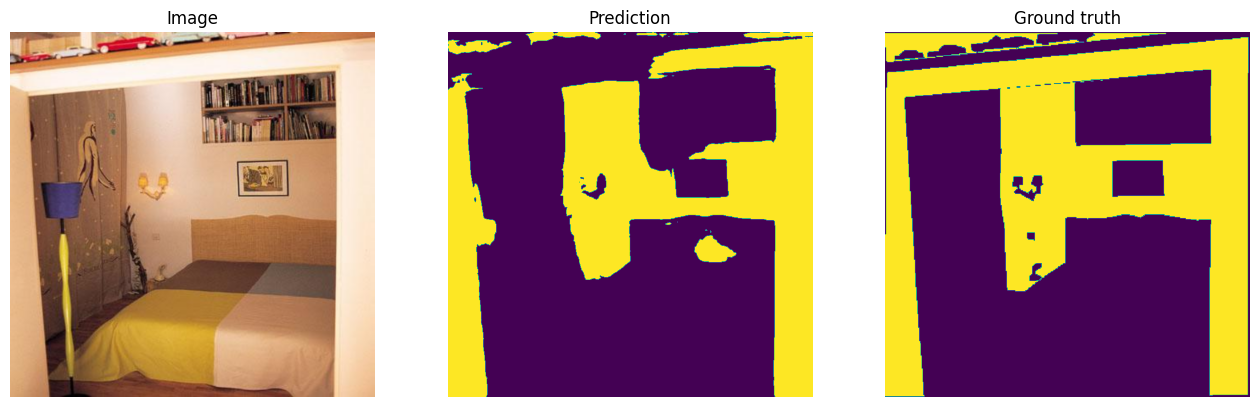

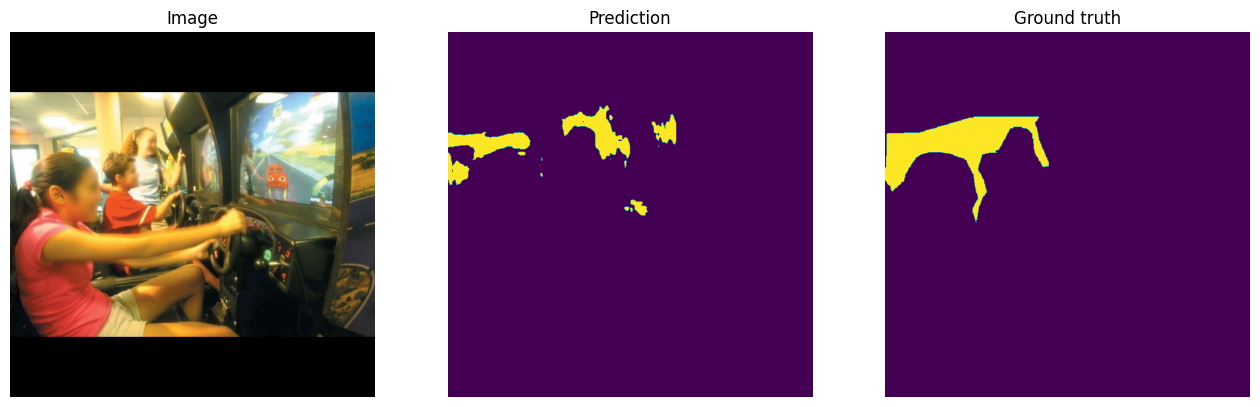

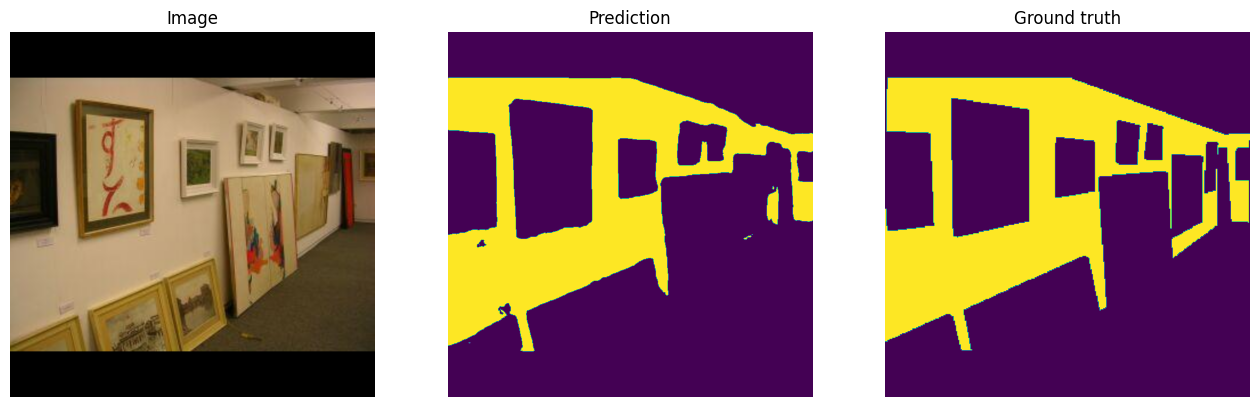

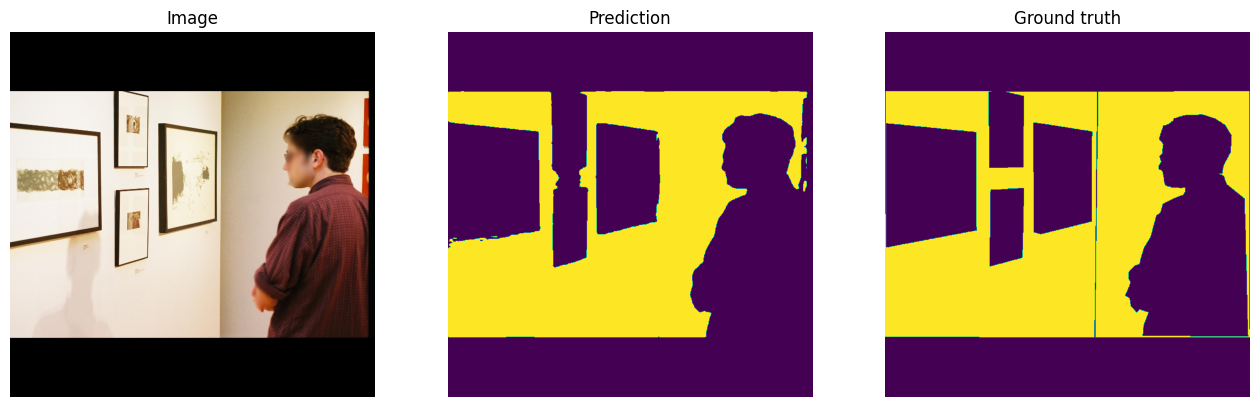

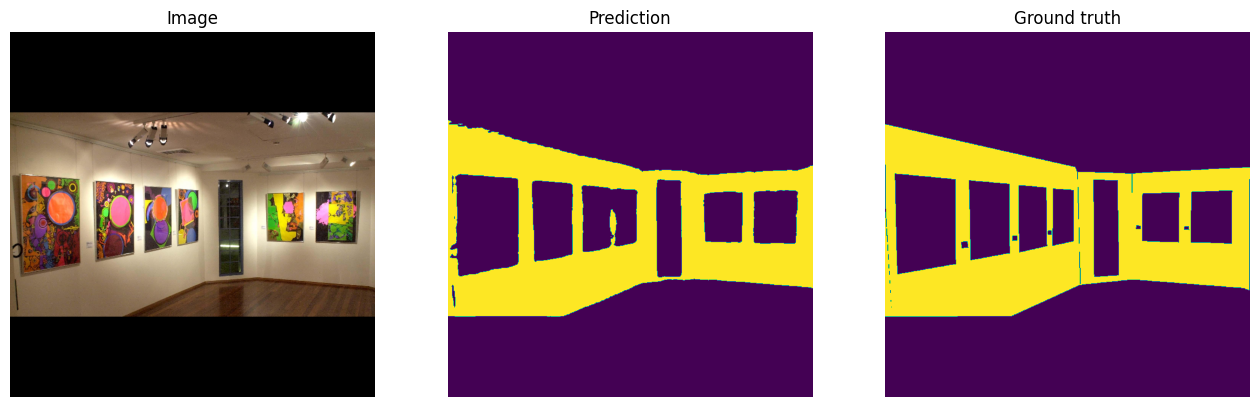

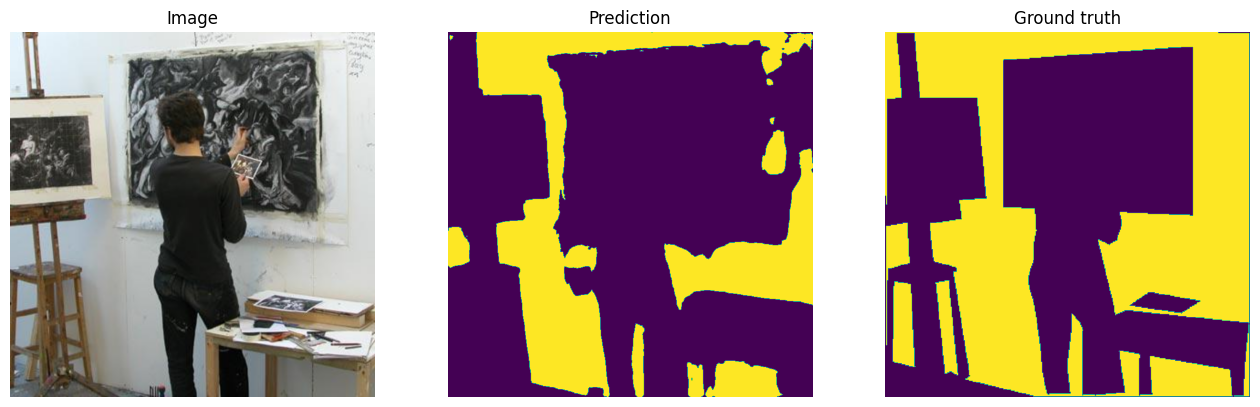

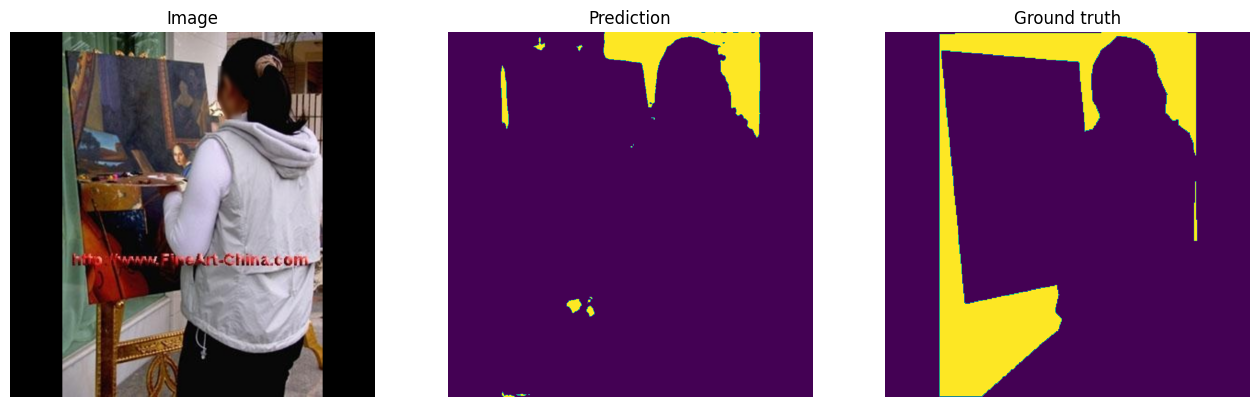

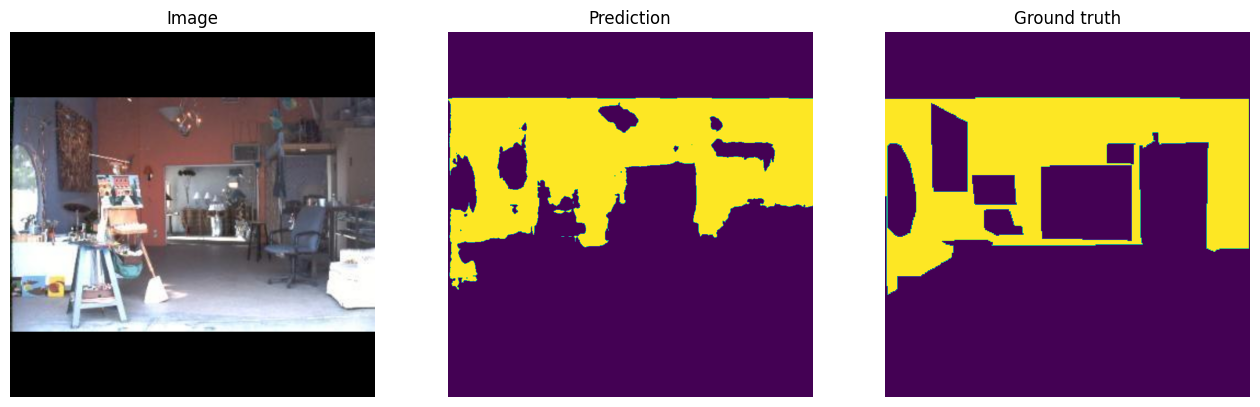

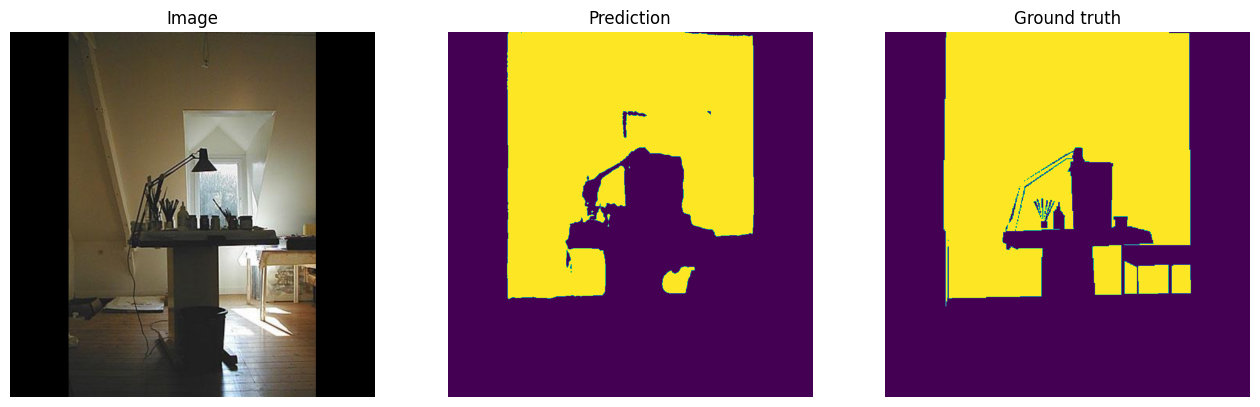

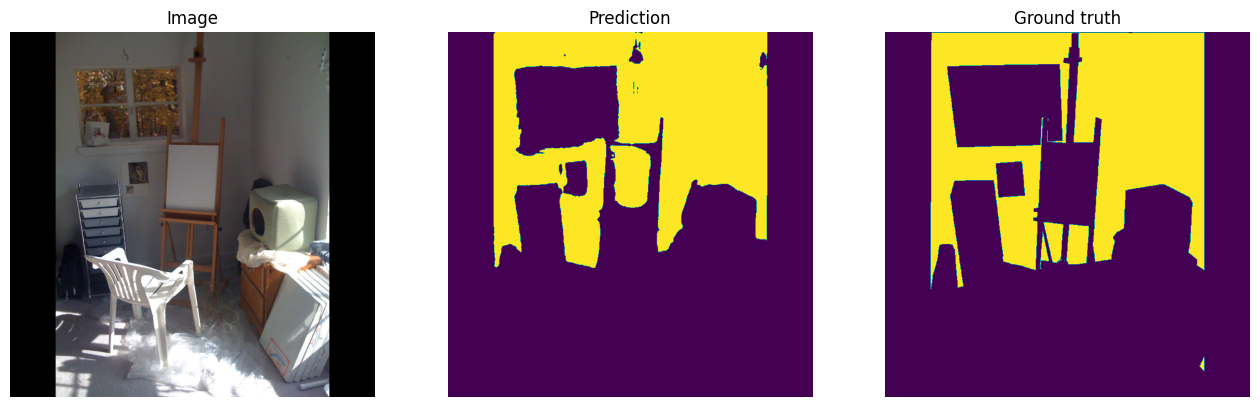

In [12]:
dataloader_iter = iter(demo_dataloader)
threshold = 0.5
for i in range(0, 10):
    image, mask = demo_dataset_vis[i]
    x, _ = next(dataloader_iter)
    # x = x.cuda()
    y = wall_model(x).cpu().detach().numpy().squeeze()
    y[y >= threshold] = 1.0
    y[y < threshold] = 0.0
    # TODO: threshold

    show_images([
        ('Image', image),
        ('Prediction', y),
        ('Ground truth', mask),
    ])

In [13]:
y[y >= 0.5] = 1.0
y[y < 0.5] = 0.0

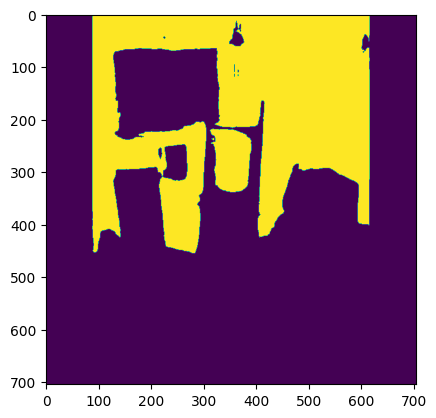

In [14]:
plt.imshow(y);